In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor

from scipy.stats import randint, uniform

In [2]:
# from catboost import CatBoostClassifier

# <font color='butter'> 1. Basic Data Cleaning Test/Train/Split

## <font color='green'> 1.1 Reading in the data & Inspection

<font style="font-family">coolkid needs to be chilled in notebooks

In [3]:
raw_data = pd.read_csv("../data/car_insurance_claim.csv")

In [4]:
pd.set_option('display.max_columns', None)
print(raw_data.head())

          ID  KIDSDRIV    BIRTH   AGE  HOMEKIDS   YOJ   INCOME PARENT1  \
0   63581743         0  16MAR39  60.0         0  11.0  $67,349      No   
1  132761049         0  21JAN56  43.0         0  11.0  $91,449      No   
2  921317019         0  18NOV51  48.0         0  11.0  $52,881      No   
3  727598473         0  05MAR64  35.0         1  10.0  $16,039      No   
4  450221861         0  05JUN48  51.0         0  14.0      NaN      No   

   HOME_VAL MSTATUS GENDER      EDUCATION     OCCUPATION  TRAVTIME  \
0        $0    z_No      M            PhD   Professional        14   
1  $257,252    z_No      M  z_High School  z_Blue Collar        22   
2        $0    z_No      M      Bachelors        Manager        26   
3  $124,191     Yes    z_F  z_High School       Clerical         5   
4  $306,251     Yes      M   <High School  z_Blue Collar        32   

      CAR_USE BLUEBOOK  TIF CAR_TYPE RED_CAR OLDCLAIM  CLM_FREQ REVOKED  \
0     Private  $14,230   11  Minivan     yes   $4,461      

## <font color='green'> 1.2 Basic Data Cleaning

In [5]:
# creating a copy of data
data_df = raw_data.copy()

In [6]:
print(raw_data.head())

          ID  KIDSDRIV    BIRTH   AGE  HOMEKIDS   YOJ   INCOME PARENT1  \
0   63581743         0  16MAR39  60.0         0  11.0  $67,349      No   
1  132761049         0  21JAN56  43.0         0  11.0  $91,449      No   
2  921317019         0  18NOV51  48.0         0  11.0  $52,881      No   
3  727598473         0  05MAR64  35.0         1  10.0  $16,039      No   
4  450221861         0  05JUN48  51.0         0  14.0      NaN      No   

   HOME_VAL MSTATUS GENDER      EDUCATION     OCCUPATION  TRAVTIME  \
0        $0    z_No      M            PhD   Professional        14   
1  $257,252    z_No      M  z_High School  z_Blue Collar        22   
2        $0    z_No      M      Bachelors        Manager        26   
3  $124,191     Yes    z_F  z_High School       Clerical         5   
4  $306,251     Yes      M   <High School  z_Blue Collar        32   

      CAR_USE BLUEBOOK  TIF CAR_TYPE RED_CAR OLDCLAIM  CLM_FREQ REVOKED  \
0     Private  $14,230   11  Minivan     yes   $4,461      

In [7]:
# defing updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# update colunmn names
data_df.rename(columns=col_names, inplace=True)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [9]:
# checking the missing values
data_df.isnull().sum()

ID                             0
num_young_drivers              0
date_of_birth                  0
age                            7
num_of_children                0
years_job_held_for           548
income                       570
single_parent                  0
value_of_home                575
married                        0
gender                         0
highest_education              0
occupation                   665
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
red_vehicle                    0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
new_claim_value                0
vehicle_age                  639
is_claim                       0
address_type                   0
dtype: int64

In [10]:
# check for the duplicated values
data_df.duplicated().sum()

np.int64(1)

In [11]:
# drop the duplicated value
data_df.drop_duplicates(inplace=True)

In [12]:
# define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# create a function for remove '$' and ',' also here we can use regex
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

# applying the function in data_df
data_df = format_currency_cols(data_df, currency_cols)

In [13]:
# define column that have z_prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# function to remove z prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace(['z_'], '', regex=True)
    return data

# applying func
data_df = remove_prefix(data_df, z_prefix_cols)

In [14]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


I'm gonna remove any unuseful features like:
- ID - we don't need id, cz it's an unique identifier
- date_of_birth - it duplicates the age column

In [15]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [16]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


## <font color='green'> 1.3 Creating our train/test split

    In here no test sets are provided. So, we have to create a test set, the best way would be stratified sampling to prevent bias

In [17]:
# checking for any inconsistencies in the data. I'm looking for rows where the 'new_claim_value' is greater than 0, but the 'is_claim' flag is 0. This shouldn't happen, as a non-zero claim value should always indicate a claim

# Check there are no non-zero values for 'new_calim_value' where 'is_claim' is 1
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


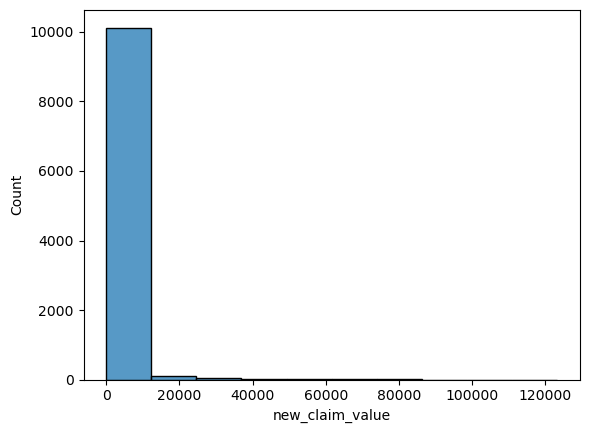

In [18]:
# creating a histplot to visualize 'new_claim_value'
sns.histplot(data_df['new_claim_value'], bins=10)
plt.show()

#### <font color="green"> feature is heavily skewed right, so I'm creating a distribution bar to see most frequent values 

In [19]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]

# Define bin labels
labels = np.arange(1, 12)

# Applying the bins using cut
data_df['claim_value_cut'] = pd.cut(data_df['new_claim_value'], bins=bins, labels=labels, include_lowest=True)

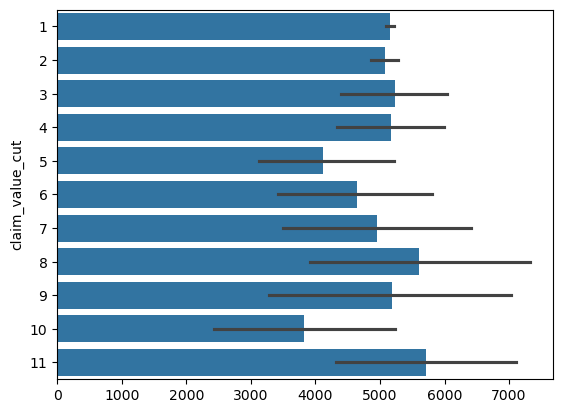

In [20]:
# visualizing 'calim_value_cut'
sns.barplot(data_df['claim_value_cut'])
plt.show()

In [21]:
# Distrubution looks ok, let's proceed to create train / test split
# create clean copy of training data

X = data_df.copy()
y = data_df['is_claim']

# Drop the target feature
X.drop(columns=['new_claim_value','is_claim'], inplace=True)

# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cut'])

     we can quickly compare the positve/negative ratios in test/train y 

In [22]:
train_ratio = round(y_train.sum() / len(y_train) * 100,2)
test_ratio = round(y_test.sum() / len(y_test) * 100,2)

print(f"Train positive class ratio: {train_ratio}%")
print(f"Test positive class ratio: {test_ratio}%")

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


     we need to drop 'calim_value_cut' from test/train sets 

In [23]:
for set_ in (X_train, y_test):
    set_.drop(columns=['claim_value_cut'], inplace=True)

# <font color='butter'> 2. Exploritary Data Analysis (EDA)

## <font color="green"> 2.1 Preparation

     for the EDA i'll join X_train, y_train so i can investigare correlation 

In [24]:
# create a copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [25]:
# I'm gonna update "yes/no", gender columns to binary, so I can see the correlation here to

binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# map values
mapping = {
    'Yes': 1,
    'No': 0,
    'yes': 1,
    'no': 0,
    'M': 1,
    'F': 0
}

In [26]:
# define function to apply those changes

def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

In [27]:
# call the function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [28]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


## <font color="green"> 2.2 Correlation Matrix

In [29]:
# I'm gonna create a correlation matrix for just my target variable

eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
is_claim,0.109085,-0.107146,0.128697,-0.053815,-0.147085,0.154323,-0.193881,-0.132326,-0.021205,0.044019,-0.103979,-0.082839,-0.007045,0.147094,0.224952,0.158972,0.218605,-0.113344,1.000000
5_year_num_of_claims,0.034724,-0.037820,0.038404,-0.026019,-0.044323,0.060335,-0.092703,-0.070880,0.014060,0.006396,-0.034264,-0.015396,0.027464,0.491048,1.000000,0.054301,0.403083,-0.023960,0.224952
license_points,0.052874,-0.079780,0.071365,-0.040719,-0.065223,0.074748,-0.097057,-0.050486,-0.006218,0.006975,-0.053148,-0.032602,0.004845,0.267866,0.403083,0.054818,1.000000,-0.035502,0.218605
licence_revoked,0.040039,-0.045184,0.051109,-0.009085,-0.031050,0.052374,-0.048395,-0.039376,-0.024676,0.002763,-0.028597,-0.029388,-0.018617,0.422329,0.054301,1.000000,0.054818,-0.027414,0.158972
single_parent,0.204141,-0.314111,0.456293,-0.027043,-0.069598,1.000000,-0.248240,-0.476495,-0.061451,-0.016323,-0.042579,0.009828,-0.039510,0.044080,0.060335,0.052374,0.074748,-0.063892,0.154323
5_year_total_claims_value,0.035981,-0.040818,0.049397,-0.005708,-0.049042,0.044080,-0.067330,-0.043098,-0.009735,-0.017241,-0.030692,-0.012395,0.006578,1.000000,0.491048,0.422329,0.267866,-0.031716,0.147094
num_of_children,0.461488,-0.448207,1.000000,0.079570,-0.158150,0.456293,-0.106974,0.037708,-0.114426,-0.000621,-0.109210,0.012882,-0.072370,0.049397,0.038404,0.051109,0.071365,-0.152561,0.128697
num_young_drivers,1.000000,-0.076813,0.461488,0.038082,-0.046508,0.204141,-0.022470,0.037441,-0.041781,0.012918,-0.026245,-0.004106,-0.045062,0.035981,0.034724,0.040039,0.052874,-0.062621,0.109085
commute_dist,0.012918,0.003201,-0.000621,-0.008878,-0.051479,-0.016323,-0.031111,0.007881,-0.007181,1.000000,-0.024179,-0.002833,0.015903,-0.017241,0.006396,0.002763,0.006975,-0.037156,0.044019
red_vehicle,-0.045062,0.028833,-0.072370,0.054180,0.061301,-0.039510,0.027262,-0.018030,0.664545,0.015903,0.028362,-0.010116,1.000000,0.006578,0.027464,-0.018617,0.004845,0.012896,-0.007045


<Axes: >

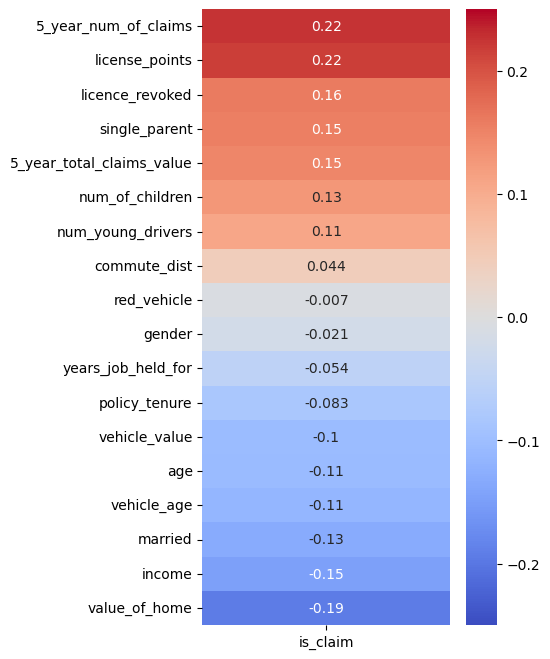

In [30]:
# seaborn plot to create a single column heatmap plot, sorted by correlation value

fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)

### Observations
- positive correlations 
    - 5_year_num_of_claims: 
    - license_points: 
    - license_revoked:
- strong negative correlation
    - Home Value
- Negligable Correlation
    - Commute Distance
    - red vehicle
    - gender

Maybe i could remove negligables, cz reduce number of features passed to the models

# <font color="butter"> 3. Data Cleaning & Preprocessing

## <font color="green"> 3.1 Dropping Features

In [31]:
# drop 'red_vehicle'

X_train_raw = X_train.copy()

col_to_drop = [
    'red_vehicle'
]

X_train_raw.drop(columns=col_to_drop, axis=1, inplace=True)

In [32]:
# no 'red_vehicle' in X_train_raw

print(X_train_raw.head())

      num_young_drivers   age  num_of_children  years_job_held_for  income  \
8452                  0  57.0                0                 NaN   33707   
7822                  2  41.0                3                14.0   17321   
1312                  0  29.0                2                12.0   54310   
921                   0  46.0                1                13.0   62886   
8708                  0  39.0                0                 8.0  115182   

     single_parent  value_of_home married gender highest_education  \
8452            No              0      No      F      <High School   
7822            No         109835     Yes      F      <High School   
1312           Yes         174139      No      M      <High School   
921            Yes         202178      No      F         Bachelors   
8708            No         312887     Yes      M       High School   

        occupation  commute_dist type_of_use  vehicle_value  policy_tenure  \
8452   Blue Collar            40

## <font color='green'> 3.2 Handling Missing Values

In [33]:
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

    I'm going to use KNN to impute this missing values

In [44]:
# create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# defining numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# defining the categorical columns
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [35]:
# define functions to impute these
def num_knn_impute_data(data, cols, imputer):
    data = data[cols]
    imputed_data = pd.DataFrame(imputer.fit_transform(data))
    imputed_data.columns = data.columns
    return imputed_data

# Run the function to impute numerical values with knn
num_test_imputed_data = num_knn_impute_data(X_train_raw, numerical_cols, knn_imputer)

In [36]:
# I'm gonna check - numerical columns missing values
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)

# Select rows wtih missing values and viewing
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [37]:
# Show same records after imputation

samples = missing_data_df.index.to_list()
num_test_imputed_data.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


    for categforical var imputation i'm gonna use the 'most_frequent' startegy

In [38]:
# initialize the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# define the function to impute the data frame
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    cat_imputed_data = pd.DataFrame(imputer.fit_transform(data))
    cat_imputed_data.columns = data.columns
    return cat_imputed_data

# run the function to impute categorical missing values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

In [39]:
# checking the data imputation functions
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)

# select rows with missing values to see, is it actually imputed or not
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


In [40]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,No,Highly Urban/ Urban


    now i'm gonna join both of categorical, numerical imputations and create a new DF

In [41]:
train_imputed_df = pd.concat([num_test_imputed_data, cat_test_data_imputed], axis=1)
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [42]:
# check missing values
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
license_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

## <font color='green'> 3.4 Categorical Feature Encoding

    so obviousely, i'm gonna use this in my ml algorithms, So i need to consider how i will encode these categericol features

In [43]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

### <font color='green'> Observations

    single parent - two values - binary encoding
    married - two values - binary encoding
    gender - two values - binary encoding
    highest_education - 5 unique vlaues - we can rank those, ordianl encoding
    occupation - 8 values with no order/rank - one-hot encoding
    vahicle_type - two values - binary encoding
    licence_revoked - two values - binary encoding
    address_type - two values - binary encoding

    ** scikit-learn has no binary-encoding option currently for independent features, i'm gonna use ordinal encoding 

In [45]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']